# Creating a PINN to simulation 2D incompressible Navier-Stokes

We will taken training data from OpenFOAM tutorial.

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import Ofpp as ofpp
import matplotlib.animation as animation
import os
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [96]:
#Data wrangling to get 1D tensors for X,Y,t,u,v,p for interior and boundary conditions
#Convert to correct format
#Scaling
#Train-test split
#QC of train-test split
#Define NN structure
#Train network
#QC prediction

In [97]:
#Read in key parameters from control dict eventually
openfoam_case_path = "../../data/cavity-re100/"

start_time = 0
end_time = 5
dt = 0.005
ofoam_write_interval = 1
ofoam_output_inc = dt * ofoam_write_interval
ofoam_num_outputs = ( end_time / ofoam_output_inc ) + 1
numt = len(np.arange(start_time,end_time + ofoam_output_inc,ofoam_output_inc))

x_start = 0
x_end = 1
numx = 20

y_start = 0
y_end = 19
numy = 20

shape = (numt,numy,numx)
print(f"OpenFOAM data shape: {shape}")

print(f"Start: {start_time} end: {end_time}")
print(f"dt: {dt} num timesteps: {numt}")
print(f"Write interval: {ofoam_write_interval} ofoam_num_outputs: {ofoam_num_outputs}")

grid2d_x, grid2d_y = np.meshgrid(
    np.linspace(x_start,x_end,numx),
    np.linspace(y_start,y_end,numy))

u_full = np.zeros(shape)
v_full = np.zeros(shape)
p_full = np.zeros(shape)

openfoam_outputs = os.listdir(openfoam_case_path)
openfoam_outputs.remove("constant")
openfoam_outputs.remove("system")
openfoam_outputs.remove("0_orig")
openfoam_outputs.sort()
openfoam_outputs = openfoam_outputs[::ofoam_write_interval]

idx = 0
for time in openfoam_outputs:
    openfoam_timestep = openfoam_case_path + time
    if time == "0":
        u_full[idx,:,:] = 0
        u_full[idx,-1,:] = 1 #Initial condition, last row all columns
        
        v_full[idx,:,:] = 0
        
        p_full[idx,:,:] = 0
    else:
        U = ofpp.parse_internal_field(f"{openfoam_timestep}/U")
        u_full[idx,:,:] = U[:,0].reshape((numy,numx))
        v_full[idx,:,:] = U[:,1].reshape((numy,numx))
        
        p_full[idx,:,:] = ofpp.parse_internal_field(f"{openfoam_timestep}/p").reshape((numy,numx))
    
    idx += 1


OpenFOAM data shape: (1001, 20, 20)
Start: 0 end: 5
dt: 0.005 num timesteps: 1001
Write interval: 1 ofoam_num_outputs: 1001.0


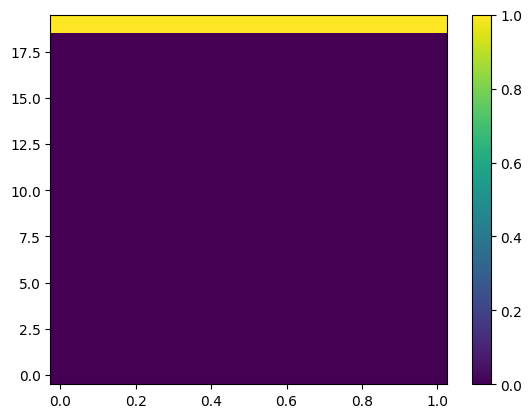

In [98]:
fig, ax = plt.subplots()
fig.colorbar(ax.pcolormesh(grid2d_x, grid2d_y, u_full[0,:,:], shading='gouraud'), orientation='vertical')
ax.pcolormesh(grid2d_x, grid2d_y,u_full[0,:,:])
plt.show()

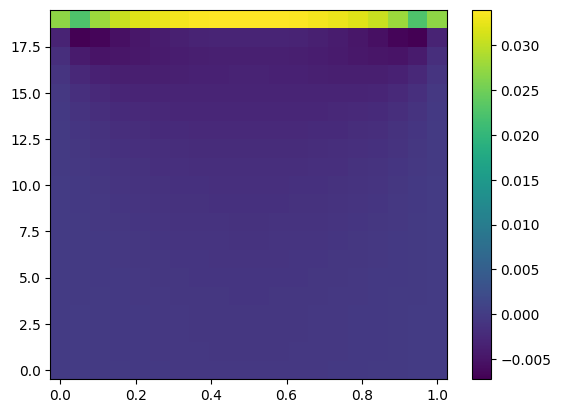

In [99]:
fig, ax = plt.subplots()
fig.colorbar(ax.pcolormesh(grid2d_x, grid2d_y, u_full[1,:,:], shading='gouraud'), orientation='vertical')
ax.pcolormesh(grid2d_x, grid2d_y,u_full[1,:,:])
plt.show()

In [100]:
#Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [101]:
y, x, t = np.meshgrid(
    np.linspace(y_start,y_end,numy),
    np.linspace(start_time,end_time+dt,numt), #z direction
    np.linspace(x_start,x_end,numx)) #cols

print(x.shape)

#Return an array in form t, x, y
features = np.concatenate((x.flatten().reshape(-1,1),y.flatten().reshape(-1,1),t.flatten().reshape(-1,1)), axis=1)
print(features.shape)

(1001, 20, 20)
(400400, 3)


OK, so we have our features x,y and t locations.

In the order T,Y,X

Now we need to extract our labels ensuring that the arrays are reshaped the same way as the features arrays.

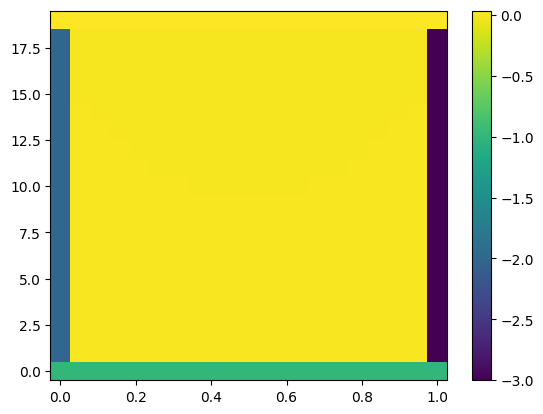

In [102]:
#Lets check our numpy slicing syntax is correct by labelling the boundary locations on a plot

tmp_u = u_full[1,:,:]
tmp_u[0,:] = -1 #bottom wall
tmp_u[1:-1,0] = -2 #left wall
tmp_u[1:-1,-1] = -3 #right wall

fig, ax = plt.subplots()
fig.colorbar(ax.pcolormesh(grid2d_x, grid2d_y, tmp_u, shading='gouraud'), orientation='vertical')
ax.pcolormesh(grid2d_x, grid2d_y, tmp_u)
plt.show()


In [103]:
u_basewall  = u_full[:,0,:]
u_leftwall  = u_full[:,1:-1,0]
u_rightwall = u_full[:,1:-1,-1]

u_basewall_labels = u_basewall.flatten().reshape(-1,1)
u_leftwall_labels = u_leftwall.flatten().reshape(-1,1)
u_rightwall_labels = u_rightwall.flatten().reshape(-1,1)

v_basewall  = v_full[:,0,:]
v_leftwall  = v_full[:,1:-1,0]
v_rightwall = v_full[:,1:-1,-1]

v_basewall_labels = v_basewall.flatten().reshape(-1,1)
v_leftwall_labels = v_leftwall.flatten().reshape(-1,1)
v_rightwall_labels = v_rightwall.flatten().reshape(-1,1)

p_basewall  = p_full[:,0,:]
p_leftwall  = p_full[:,1:-1,0]
p_rightwall = p_full[:,1:-1,-1]

p_basewall_labels = p_basewall.flatten().reshape(-1,1)
p_leftwall_labels = p_leftwall.flatten().reshape(-1,1)
p_rightwall_labels = p_rightwall.flatten().reshape(-1,1)

print(u_basewall.shape)
print(u_leftwall.shape)
print(u_rightwall.shape)

print(u_basewall_labels.shape)
print(u_leftwall_labels.shape)
print(u_rightwall_labels.shape)

(1001, 20)
(1001, 18)
(1001, 18)
(20020, 1)
(18018, 1)
(18018, 1)


In [104]:
basewall_features_x = x[:,0,:]
basewall_features_y = y[:,0,:]
basewall_features_t = t[:,0,:]

leftwall_features_x = x[:,1:-1,0]
leftwall_features_y = y[:,1:-1,0]
leftwall_features_t = t[:,1:-1,0]

rightwall_features_x = x[:,1:-1,-1]
rightwall_features_y = y[:,1:-1,-1]
rightwall_features_t = t[:,1:-1,-1]

features_basewall = np.concatenate(
    (
        basewall_features_x.flatten().reshape(-1,1),
        basewall_features_y.flatten().reshape(-1,1),
        basewall_features_t.flatten().reshape(-1,1)
    ), 
    axis=1)

features_leftwall = np.concatenate(
    (
        leftwall_features_x.flatten().reshape(-1,1),
        leftwall_features_y.flatten().reshape(-1,1),
        leftwall_features_t.flatten().reshape(-1,1)
    ), 
    axis=1)

features_rightwall = np.concatenate(
    (
        rightwall_features_x.flatten().reshape(-1,1),
        rightwall_features_y.flatten().reshape(-1,1),
        rightwall_features_t.flatten().reshape(-1,1)
    ), 
    axis=1)

print(features_basewall.shape)
print(features_rightwall.shape)
print(features_leftwall.shape)

print("Starting index for each boundary (t,y,x)")
print(features_basewall[0,...])
print(features_rightwall[0,...])
print(features_leftwall[0,...])

print("Final index for each boundary (t,y,x)")
print(features_basewall[-1,...])
print(features_rightwall[-1,...])
print(features_leftwall[-1,...])


(20020, 3)
(18018, 3)
(18018, 3)
Starting index for each boundary (t,y,x)
[0. 0. 0.]
[0. 1. 1.]
[0. 1. 0.]
Final index for each boundary (t,y,x)
[5.005 0.    1.   ]
[ 5.005 18.     1.   ]
[ 5.005 18.     0.   ]


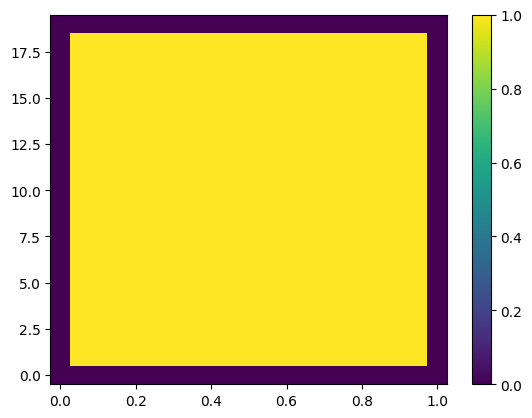

In [112]:
#Now lets get the interior datapoints
#Again lets start with a visual check of the syntax
tmp_u = np.zeros(u_full[0,:,:].shape)
tmp_u[1:-1,1:-1] = 1 #all rows and columns but first and last

#Interior should be 1, boundaries should be zero

fig, ax = plt.subplots()
fig.colorbar(ax.pcolormesh(grid2d_x, grid2d_y, tmp_u, shading='gouraud'), orientation='vertical')
ax.pcolormesh(grid2d_x, grid2d_y, tmp_u)
plt.show()

Great that looks good, lets pull out the interior labels and features from their respective arrays.

In [114]:
interior_features_x = x[:,1:-1,1:-1]
interior_features_y = y[:,1:-1,1:-1]
interior_features_t = t[:,1:-1,1:-1]

In [115]:
features_interior = np.concatenate(
    (
        interior_features_x.flatten().reshape(-1,1),
        interior_features_y.flatten().reshape(-1,1),
        interior_features_t.flatten().reshape(-1,1)
    ), 
    axis=1)

print(features_interior.shape)

print("Starting index for interior points (t,y,x)")
print(features_interior[0,...])

print("Final index for interior (t,y,x)")
print(features_interior[-1,...])


(324324, 3)
Starting index for interior points (t,y,x)
[0.         1.         0.05263158]
Final index for interior (t,y,x)
[ 5.005      18.          0.94736842]


Great that also looks good

So we now have data for the loss condition:

- boundary condition points (should all equal 0)
- interior points (should honour the PDE)

The next steps are to scale our features

In [118]:
#Feature scaling

In [119]:
#Now split each dataset into training and testing

In [ ]:
#QC training/testing selection with GIF using additional scatter ontop of quiver...will that work?

In [105]:
# Define MLP model architecture class
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        """_summary_
        """
        super().__init__()
        self.linear_stack = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3)
        )

    def forward(self, x, y, t):
        """_summary_

        Args:
            x (_type_): _description_
            t (_type_): _description_

        Returns:
            _type_: _description_
        """
        inputs = torch.cat([x,y,t], axis=1).to(device)
        return self.linear_stack(inputs)

In [106]:
#Training loop

In [107]:
#Testing loop

In [108]:
#Loss function

In [109]:
#Main function

In [110]:
#QC plot and GIF using NN to predict fluid flow